In [1]:
import datetime as dt
import sys
from os import getcwd
from os.path import dirname, join

import matplotlib.pyplot as plt
import numpy as np
import pytz

import MAMMAL.Simulator as sim
from MAMMAL.Parse import parseIM as pim
from MAMMAL.Utils import coordinateUtils as cu
from MAMMAL.Utils import mapUtils as mu
from MAMMAL.VehicleCal import TL as tl


%matplotlib inline
plt.rcParams["figure.figsize"] = (25, 20) # (w, h)


debug = True # Set to True to enable debug printouts plus plots

# Simulated Spin Test Parameters

In [2]:
spin_out_dir    = getcwd()
spin_lat        = 38.205  # Fredericksburg (dd)
spin_lon        = -77.373 # Fredericksburg (dd)
spin_height_m   = 69      # Height of Fredericksburg above MSL
spin_start_dt   = dt.datetime(2019, 9, 12, 8, 40, 0, tzinfo=pytz.utc)
spin_start_dt   = dt.datetime.fromtimestamp(spin_start_dt.timestamp())
spin_headings   = np.linspace(0, 720, 1000)
spin_elevations = np.linspace(0, 7200, 1000)
spin_a          = np.array([[0.1, 0.0, 0.0],
                            [0.0, 0.2, 0.0],
                            [0.0, 0.0, 1.0]])
spin_b          = np.array([1, 10, 20])

# Simulated Tolles-Lawson Box Flight Parameters

In [3]:
tl_out_dir    = getcwd()
tl_center_lat = 38.205  # Fredericksburg (dd)
tl_center_lon = -77.373 # Fredericksburg (dd)
tl_height_m   = 2000
tl_start_dt   = dt.datetime(2019, 9, 12, 8, 40, 0, tzinfo=pytz.utc)
tl_start_dt   = dt.datetime.fromtimestamp(tl_start_dt.timestamp())
tl_box_xlen_m = 500
tl_box_ylen_m = 1000
tl_c          = np.array([0,  # Perm x
                          0,  # Perm y
                          0,  # Perm z
                          0,  # Ind xx
                          0,  # Ind yy
                          0,  # Ind zz
                          0,  # Ind xy
                          0,  # Ind xz
                          0,  # Ind yz
                          0,  # Eddy xx'
                          0,  # Eddy yy'
                          0,  # Eddy yx'
                          0,  # Eddy yx'
                          0,  # Eddy zx'
                          0,  # Eddy xy'
                          0,  # Eddy zy'
                          0,  # Eddy xz'
                          0]) # Eddy yz'
tl_vel_mps    = 20
tl_sample_hz  = 50
tl_dither_hz  = 1
tl_dither_amp = 10
tl_terms      = tl.ALL_TERMS

# Simulated Reference Station Data Parameters

In [4]:
ref_out_dir   = getcwd()
ref_lat       = 38.205  # Fredericksburg (dd)
ref_lon       = -77.373 # Fredericksburg (dd)
ref_height_m  = 69      # Height of Fredericksburg above MSL
ref_start_dt  = dt.datetime(2019, 9, 12, 8, 40, 0, tzinfo=pytz.utc)
ref_start_dt  = dt.datetime.fromtimestamp(ref_start_dt.timestamp())
ref_dur_s     = 10000
ref_scale     = 1
ref_offset    = 0
ref_awgn_std  = 0
ref_sample_hz = 1
ref_id        = 'FRD'
ref_in_dir    = getcwd()
if ref_id is not None and ref_in_dir is not None:
    ref_file_df = pim.loadInterMagData(ref_in_dir)[ref_id]
else:
    ref_file_df = None

Loaded bou20190911psec.sec
Loaded bou20190912psec.sec
Loaded frd20190911psec.sec
Loaded frd20190912psec.sec
Loaded frn20190911psec.sec
Loaded frn20190912psec.sec


# Simulated Anomaly Map Parameters

In [5]:
map_out_dir        = getcwd()
map_loc_name       = 'test'
map_center_lat     = 38.205  # Fredericksburg (dd)
map_center_lon     = -77.373 # Fredericksburg (dd)
map_height_agl_m   = 30.48   # 100ft AGL
map_height_m       = 69 + map_height_agl_m # Height of Fredericksburg above MSL + survey height AGL
map_upcontinue     = False
map_x_dist_m       = 300
map_y_dist_m       = 300
map_dx_m           = map_height_agl_m / 20
map_dy_m           = map_height_agl_m / 20
map_start_dt       = dt.datetime(2019, 9, 12, 8, 40, 0, tzinfo=pytz.utc)
map_start_dt       = dt.datetime.fromtimestamp(map_start_dt.timestamp())
map_anomaly_locs   = np.array([[map_center_lat],  # dd
                               [map_center_lon]]) # dd
map_anomaly_scales = np.array([20]) # nT
map_anomaly_covs   = np.zeros((1, 2, 2))
map_anomaly_covs[0, :, :] = np.diag([0.000001, 0.000002])

# Simulated Survey Flight Parameters

In [6]:
survey_out_dir         = getcwd()
survey_height_m        = map_height_m
survey_start_dt        = dt.datetime(2019, 9, 12, 8, 40, 0, tzinfo=pytz.utc)
survey_start_dt        = dt.datetime.fromtimestamp(survey_start_dt.timestamp())
survey_vel_mps         = 19
survey_e_buff_m        = 15.24 # 50ft
survey_w_buff_m        = 15.24 # 50ft
survey_n_buff_m        = 15.24 # 50ft
survey_s_buff_m        = 15.24 # 50ft
survey_sample_hz       = 5
survey_ft_line_dist_m  = map_height_agl_m / 2
survey_ft_line_dir     = sim.HORIZ
survey_scalar_awgn_std = 0
survey_use_tie_lines   = True
survey_tie_dist_m      = survey_ft_line_dist_m * 5

# Generate Simulated Spin Test Data

Generating simulated spin test data
Generating perfect simulated spin test measurements
Applying vector distortion to simulated spin test data
Calculating IGRF values for simulated spin test
Exporting simulated spin test data as a CSV
Saved data to c:\Users\ltber\Downloads\mammal-Beta\mammal-Beta\data\test\spin_2019_9_12_0.csv


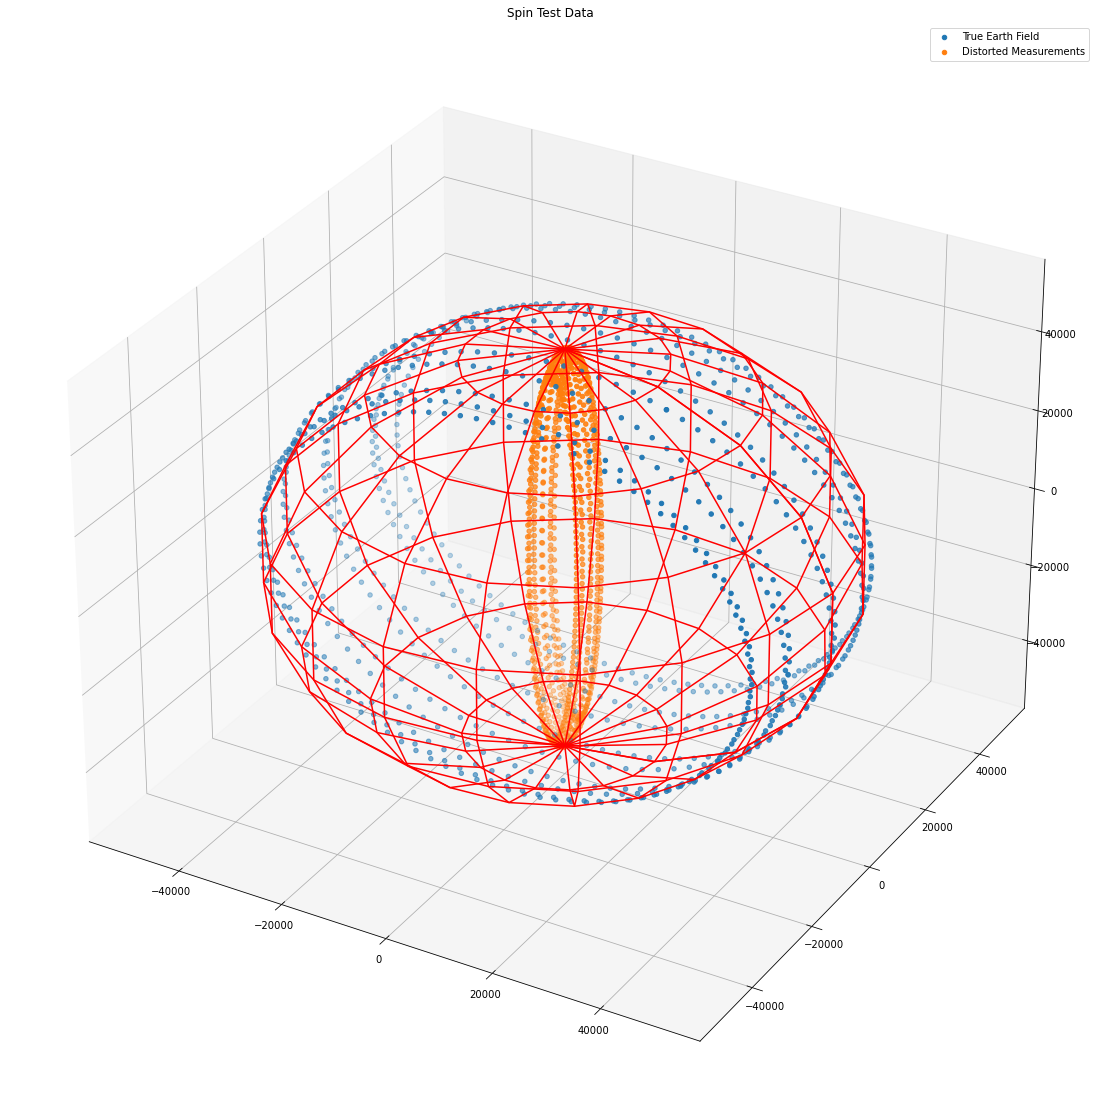

In [7]:
spin_df = sim.gen_spin_data(out_dir    = spin_out_dir,
                            lat        = spin_lat,
                            lon        = spin_lon,
                            height     = spin_height_m,
                            date       = spin_start_dt,
                            headings   = spin_headings,
                            elevations = spin_elevations,
                            a          = spin_a,
                            b          = spin_b,
                            debug      = debug)

# Generate Simulated Tolles-Lawson Box Flight Data

Generating simulated TL calibration flight data
Calculating IGRF values for simulated TL calibration flight
Dithering orientation angles (1 Hz, ±10°)
Dithering pitch angles
Dithering roll angles
Dithering azimuth angles
Generating true TL readings (assuming no anomaly - only IGRF is used)
Applying TL distortion to simulated calibration flight data
Applying spin test distortion to simulated simulated TL readings
Exporting simulated TL flight data as a CSV
Saved data to c:\Users\ltber\Downloads\mammal-Beta\mammal-Beta\data\test\tl_2019_9_12_0.csv


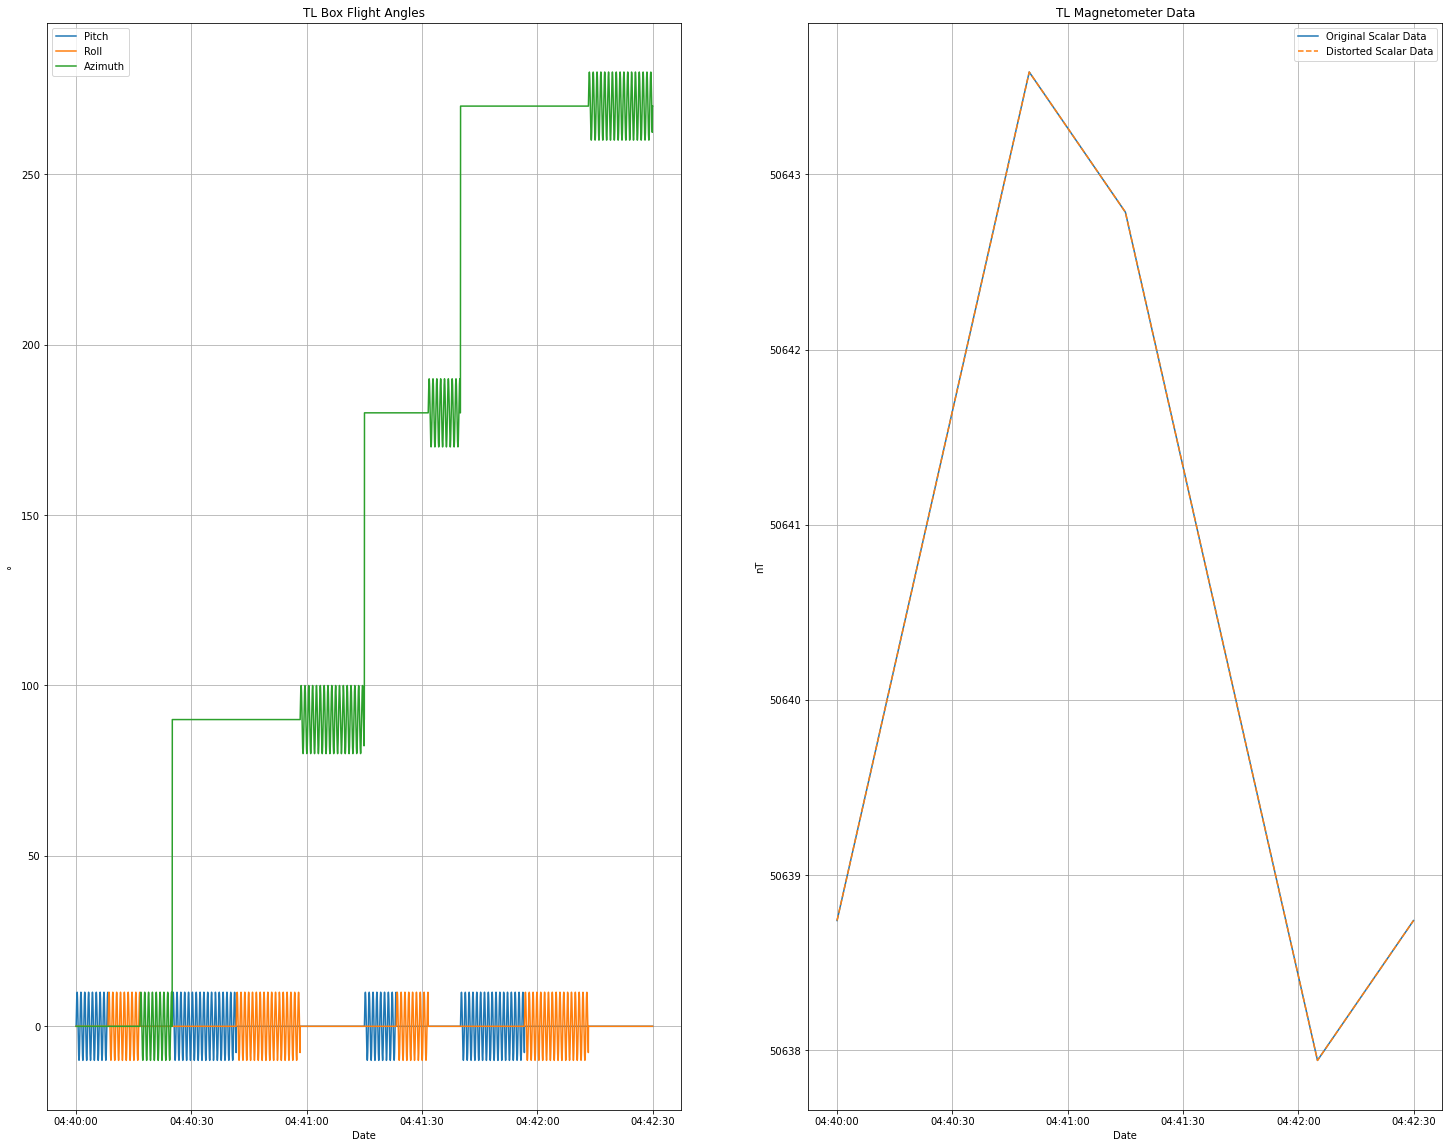

In [8]:
tl_df = sim.gen_TL_data(out_dir    = tl_out_dir,
                        center_lat = tl_center_lat,
                        center_lon = tl_center_lon,
                        height     = tl_height_m,
                        start_dt   = tl_start_dt,
                        box_xlen_m = tl_box_xlen_m,
                        box_ylen_m = tl_box_ylen_m,
                        c          = tl_c,
                        vel_mps    = tl_vel_mps,
                        sample_hz  = tl_sample_hz,
                        dither_hz  = tl_dither_hz,
                        dither_amp = tl_dither_amp,
                        terms      = tl_terms,
                        a          = spin_a,
                        b          = spin_b,
                        debug      = debug)

# Generate Simulated Reference Station Data

Generating simulated reference station data
Incorporating file data into simulated reference data
Incorporating scale and offset into simulated reference data
Incorporating AWGN into simulated reference data
Calculating IGRF values at simulated reference station
Adding IGRF core field to simulated reference station scalar values
Projecting simulated reference station scalar values into vector values using IGRF direction cosines
Exporting simulated reference station data as a CSV
Saved data to c:\Users\ltber\Downloads\mammal-Beta\mammal-Beta\data\test\ref_2019_9_12_0.csv


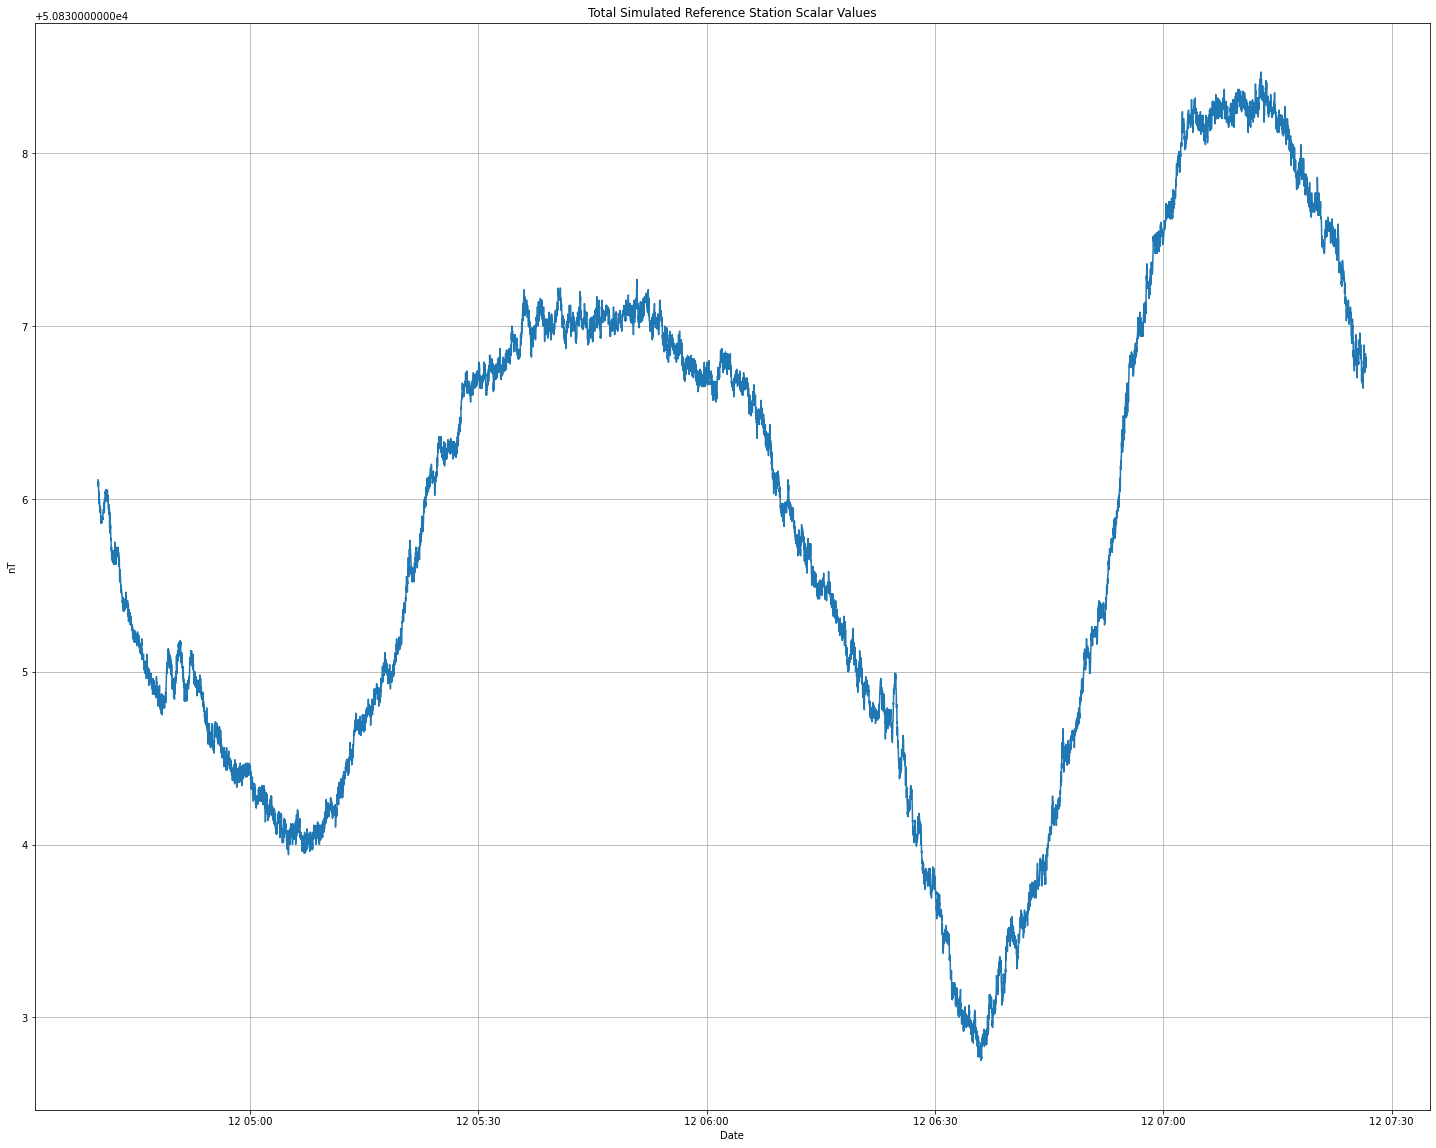

In [9]:
ref_df = sim.gen_ref_station_data(out_dir   = ref_out_dir,
                                  lat       = ref_lat,
                                  lon       = ref_lon,
                                  height    = ref_height_m,
                                  start_dt  = ref_start_dt,
                                  dur_s     = ref_dur_s,
                                  scale     = ref_scale,
                                  offset    = ref_offset,
                                  awgn_std  = ref_awgn_std,
                                  sample_hz = ref_sample_hz,
                                  file_df   = ref_file_df,
                                  debug     = debug)

# Generate Simulated Anomaly Map

Generating simulated anomaly map
Processing simulated anomaly sctructures at MSL
Calculating IGRF values for simulated map
Projecting simulated map scalar measurements into vector measurements using IGRF direction cosines
Exporting simulated map as a GeoTIFF


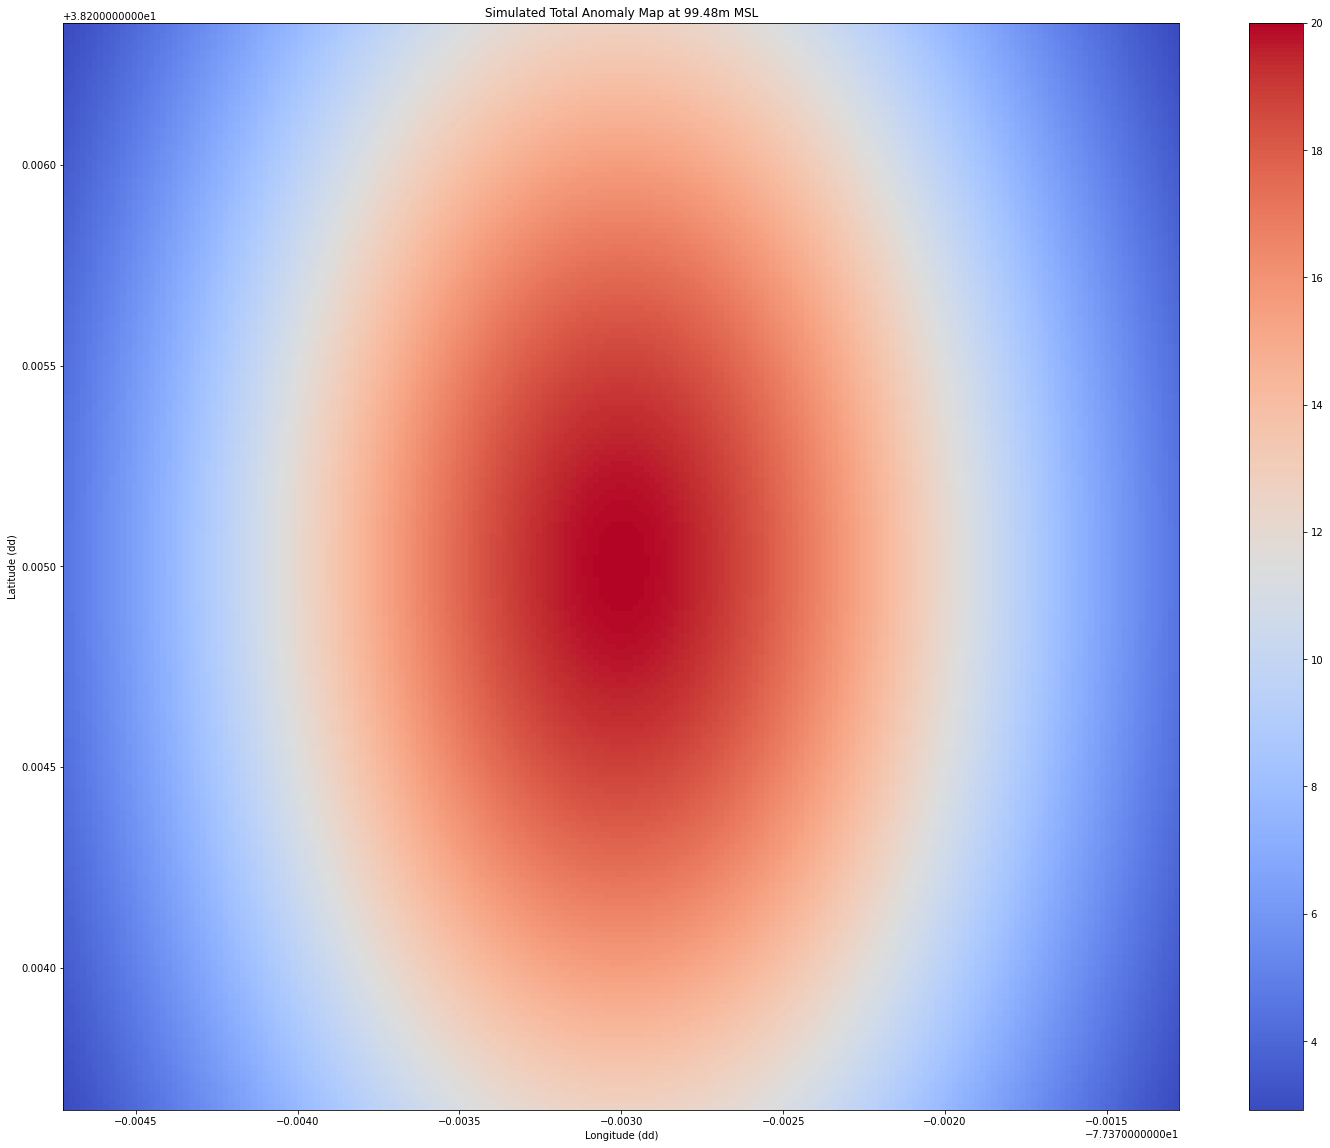

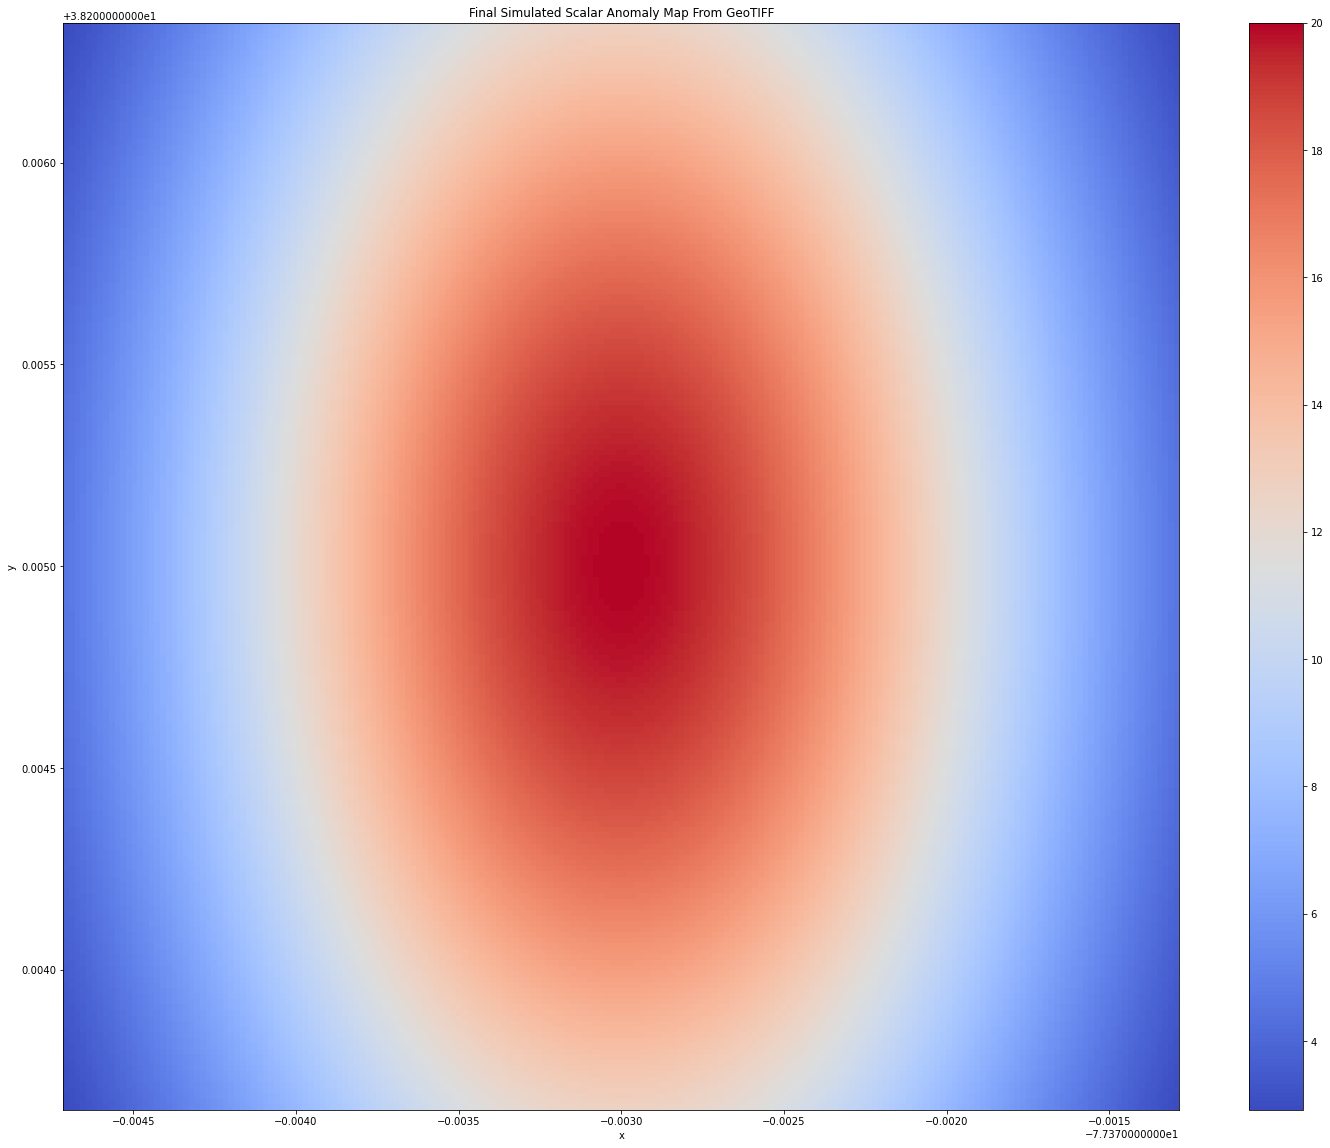

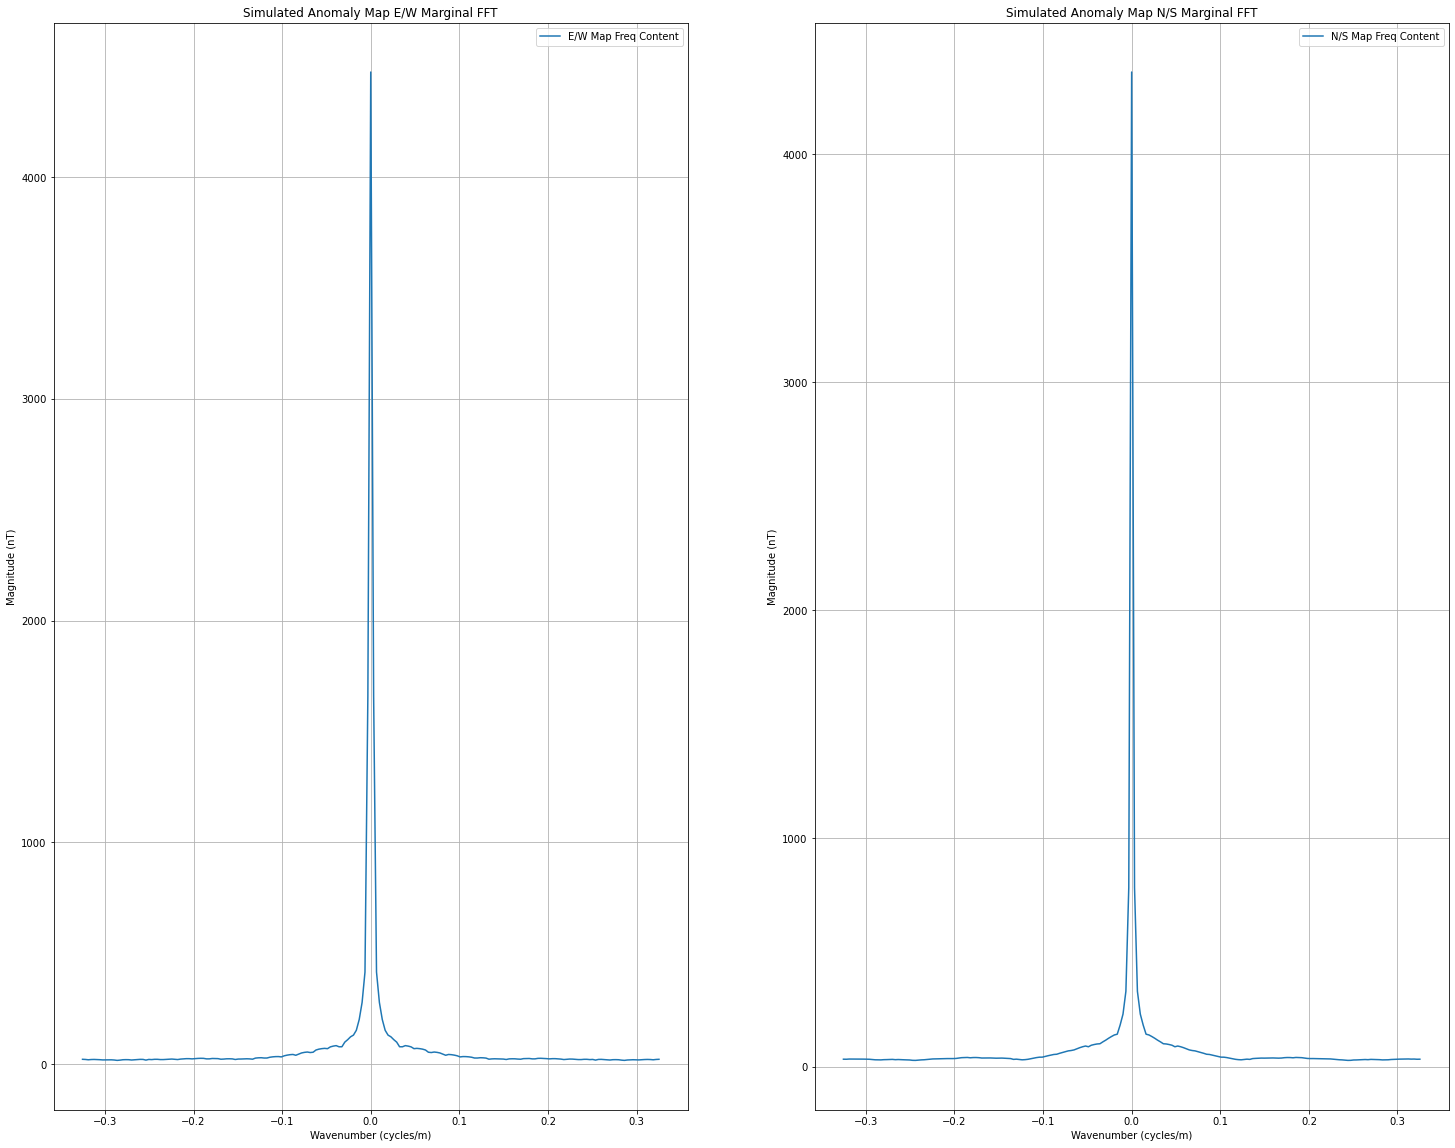

In [10]:
sim_map = sim.gen_sim_map(out_dir        = map_out_dir,
                          location       = map_loc_name,
                          center_lat     = map_center_lat,
                          center_lon     = map_center_lon,
                          dx_m           = map_dx_m,
                          dy_m           = map_dy_m,
                          x_dist_m       = map_x_dist_m,
                          y_dist_m       = map_y_dist_m,
                          height         = map_height_m,
                          date           = map_start_dt,
                          anomaly_locs   = map_anomaly_locs,
                          anomaly_scales = map_anomaly_scales,
                          anomaly_covs   = map_anomaly_covs,
                          upcontinue     = map_upcontinue,
                          debug          = debug)

if debug:
    mu.plt_freqs(sim_map[0], 'Simulated Anomaly')

# Generate Simulated Survey Flight Data

Generating simulated survey data
Generating simulated survey flight path
Calculating simulated survey scalar anomaly, azimuth, and IGRF values


100%|██████████| 1562/1562 [00:14<00:00, 110.19it/s]


Adding core field to simulated survey scalar measurements


100%|██████████| 1561/1561 [00:00<00:00, 520164.34it/s]


Adding diurnal to simulated survey scalar measurements
Applying TL distortion to simulated survey scalar measurements
Projecting simulated survey scalar measurements into NED vector measurements using IGRF direction cosines
Rotating NED vector measurements into sensor's body frame
Applying spin test distortion to simulated survey vector measurements
Exporting simulated survey data as a CSV
Survey start datetime/timestamp: 2019-09-12 04:40:00/1568277600.0s
Survey end datetime/timestamp: 2019-09-12 04:45:12.200000/1568277952.6181314s
Flight line samples end at timestamp: 1568277600.402999s
Survey Duration: 352.61813139915466s
Saved data to c:\Users\ltber\Downloads\mammal-Beta\mammal-Beta\data\test\survey_2019_9_12_0.csv


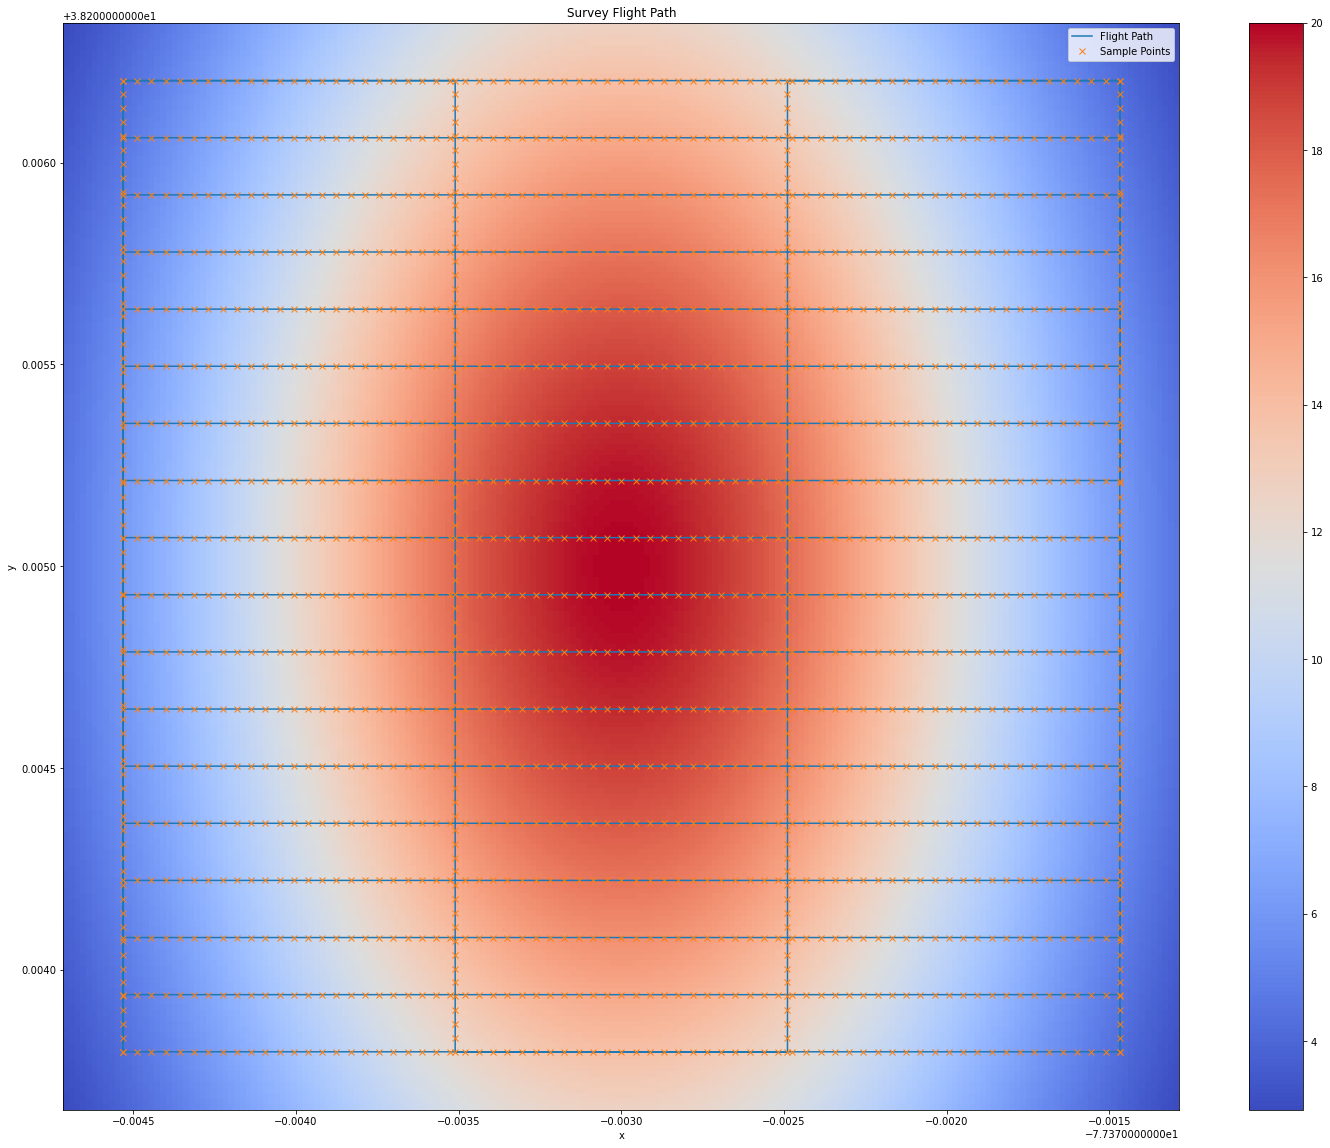

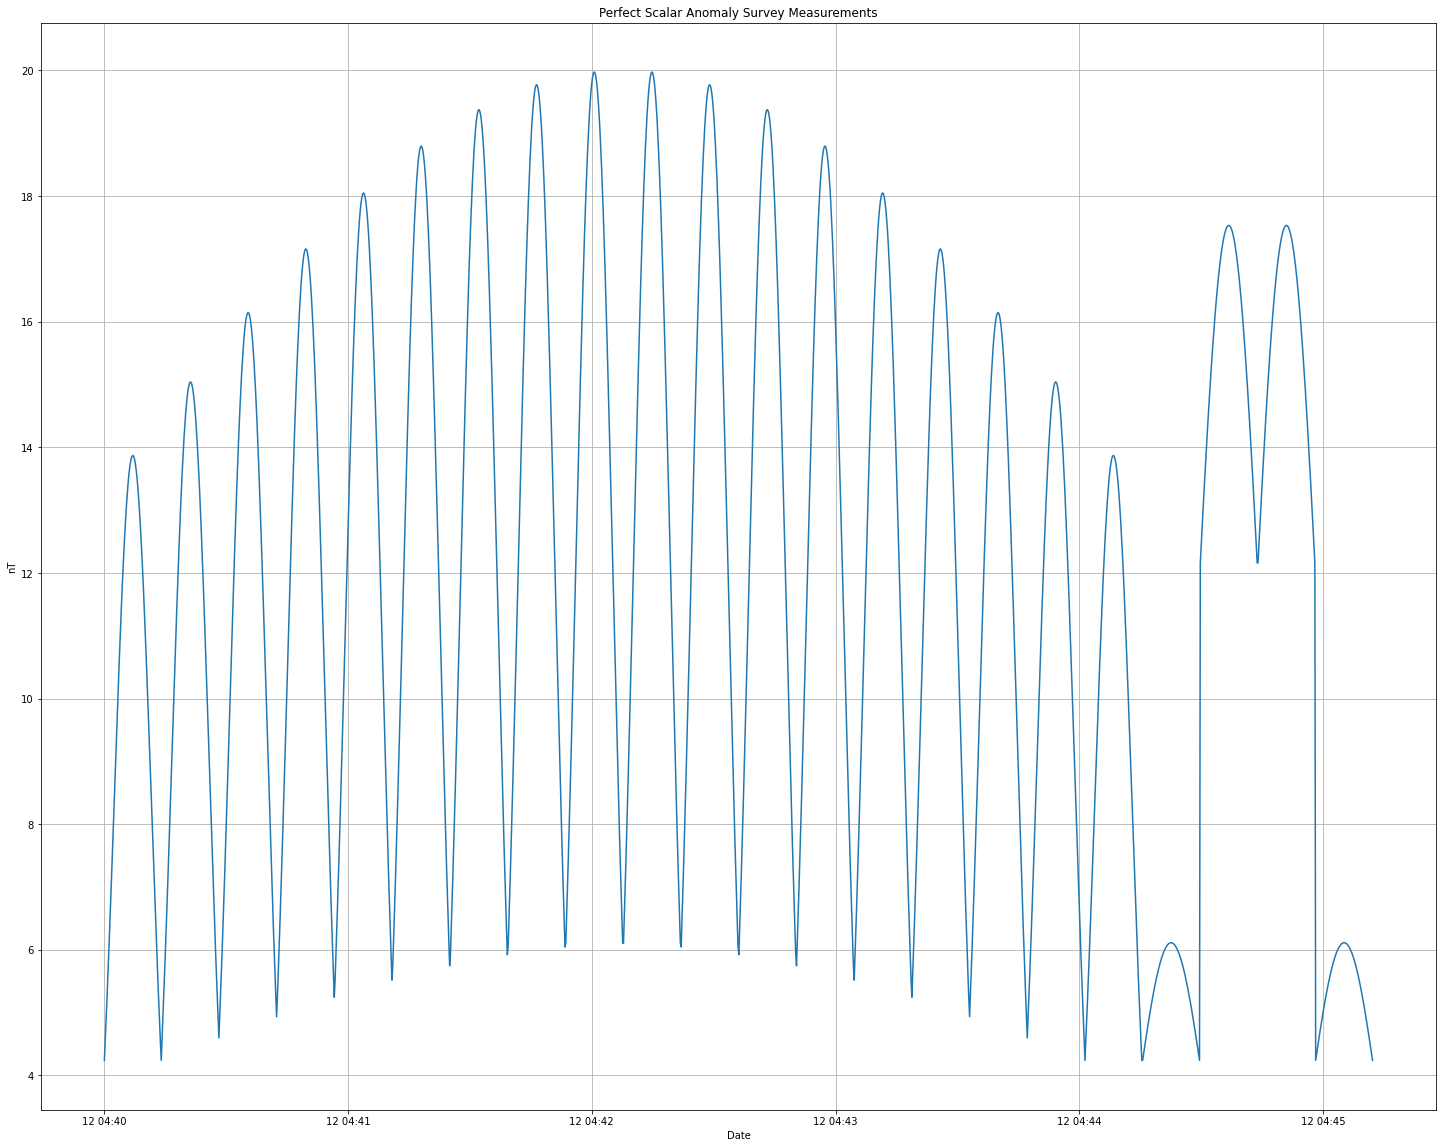

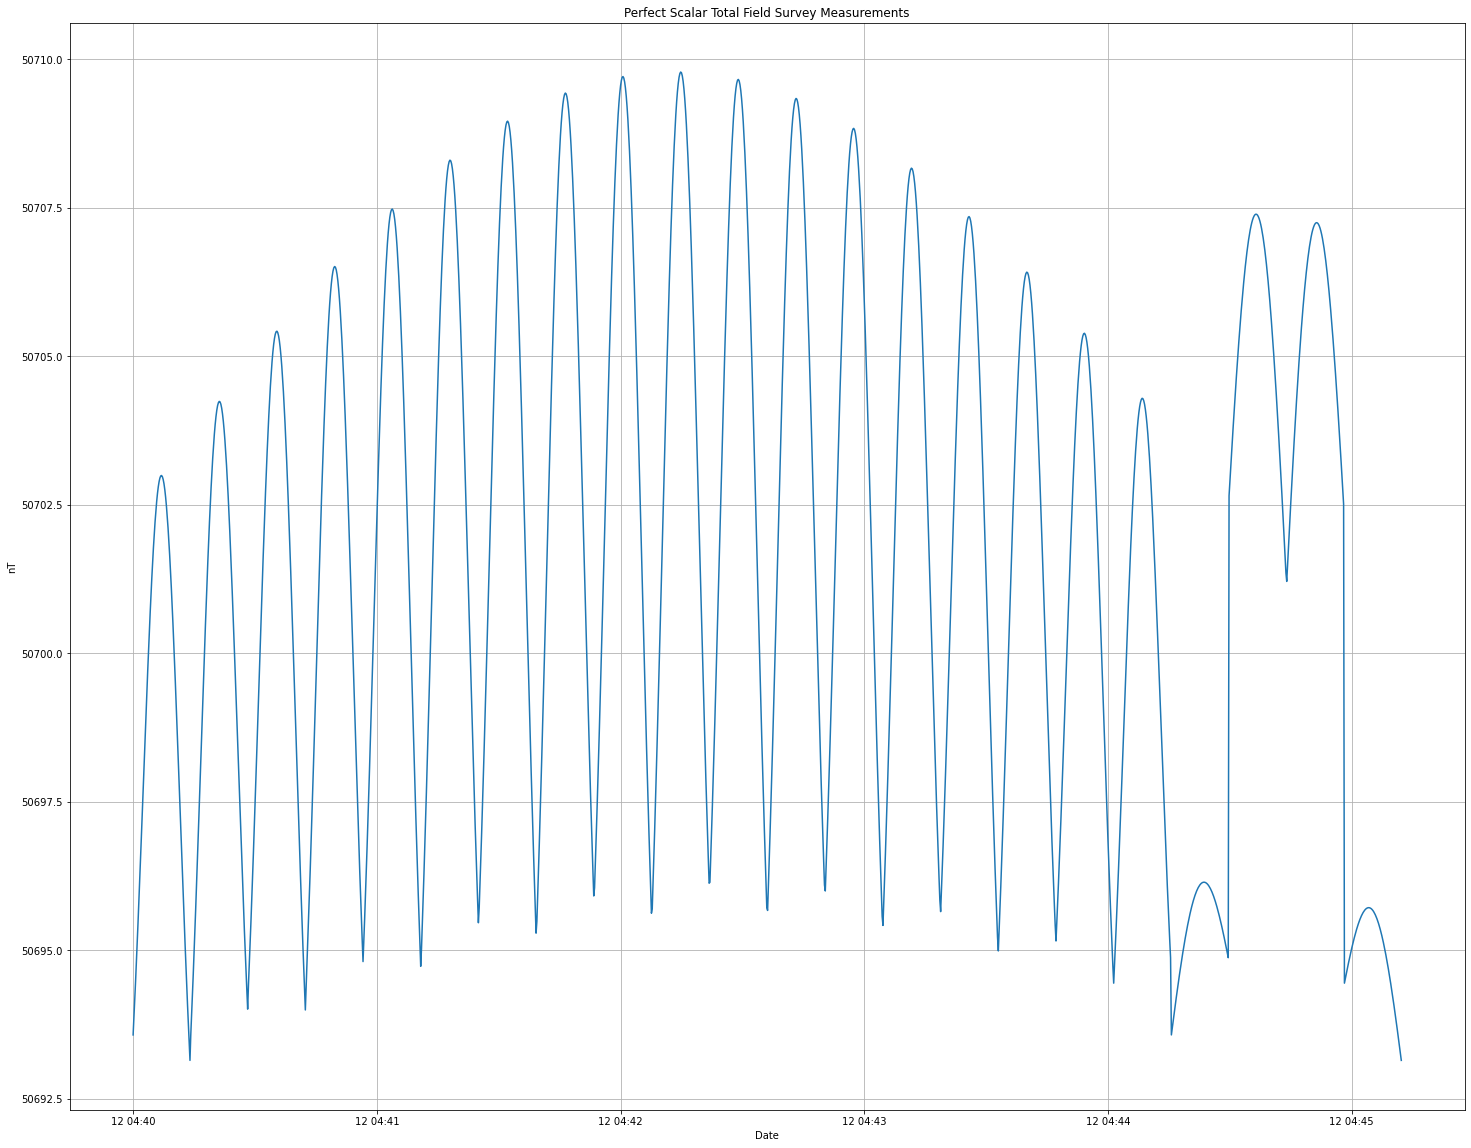

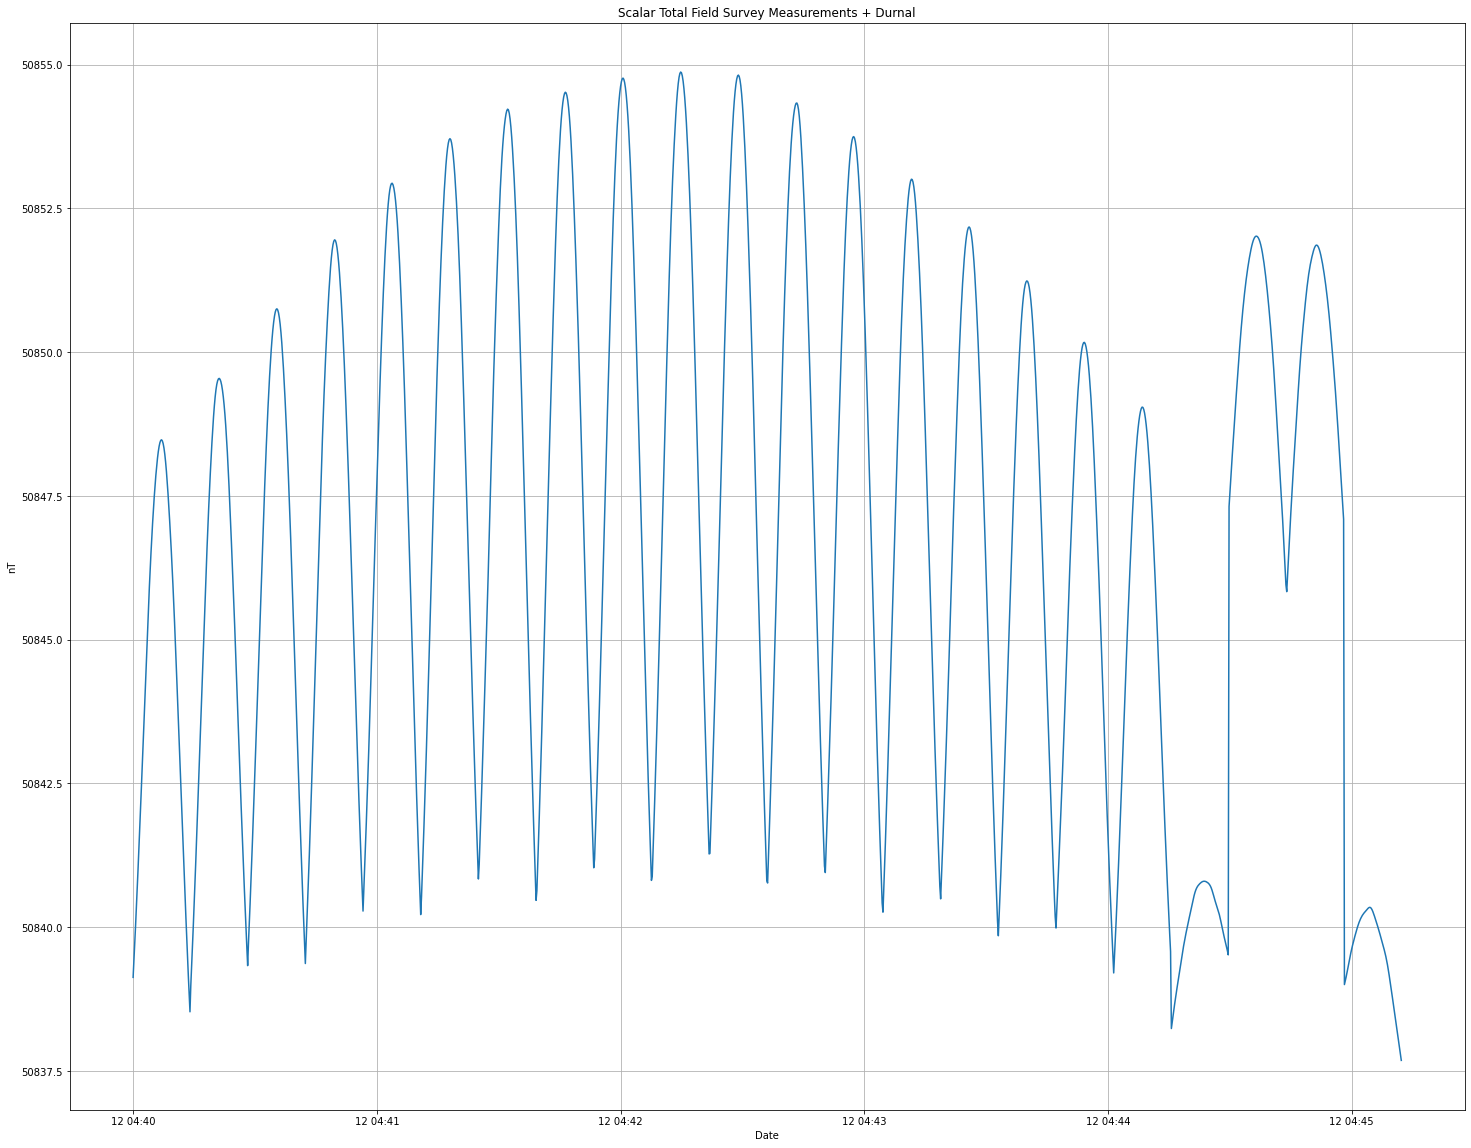

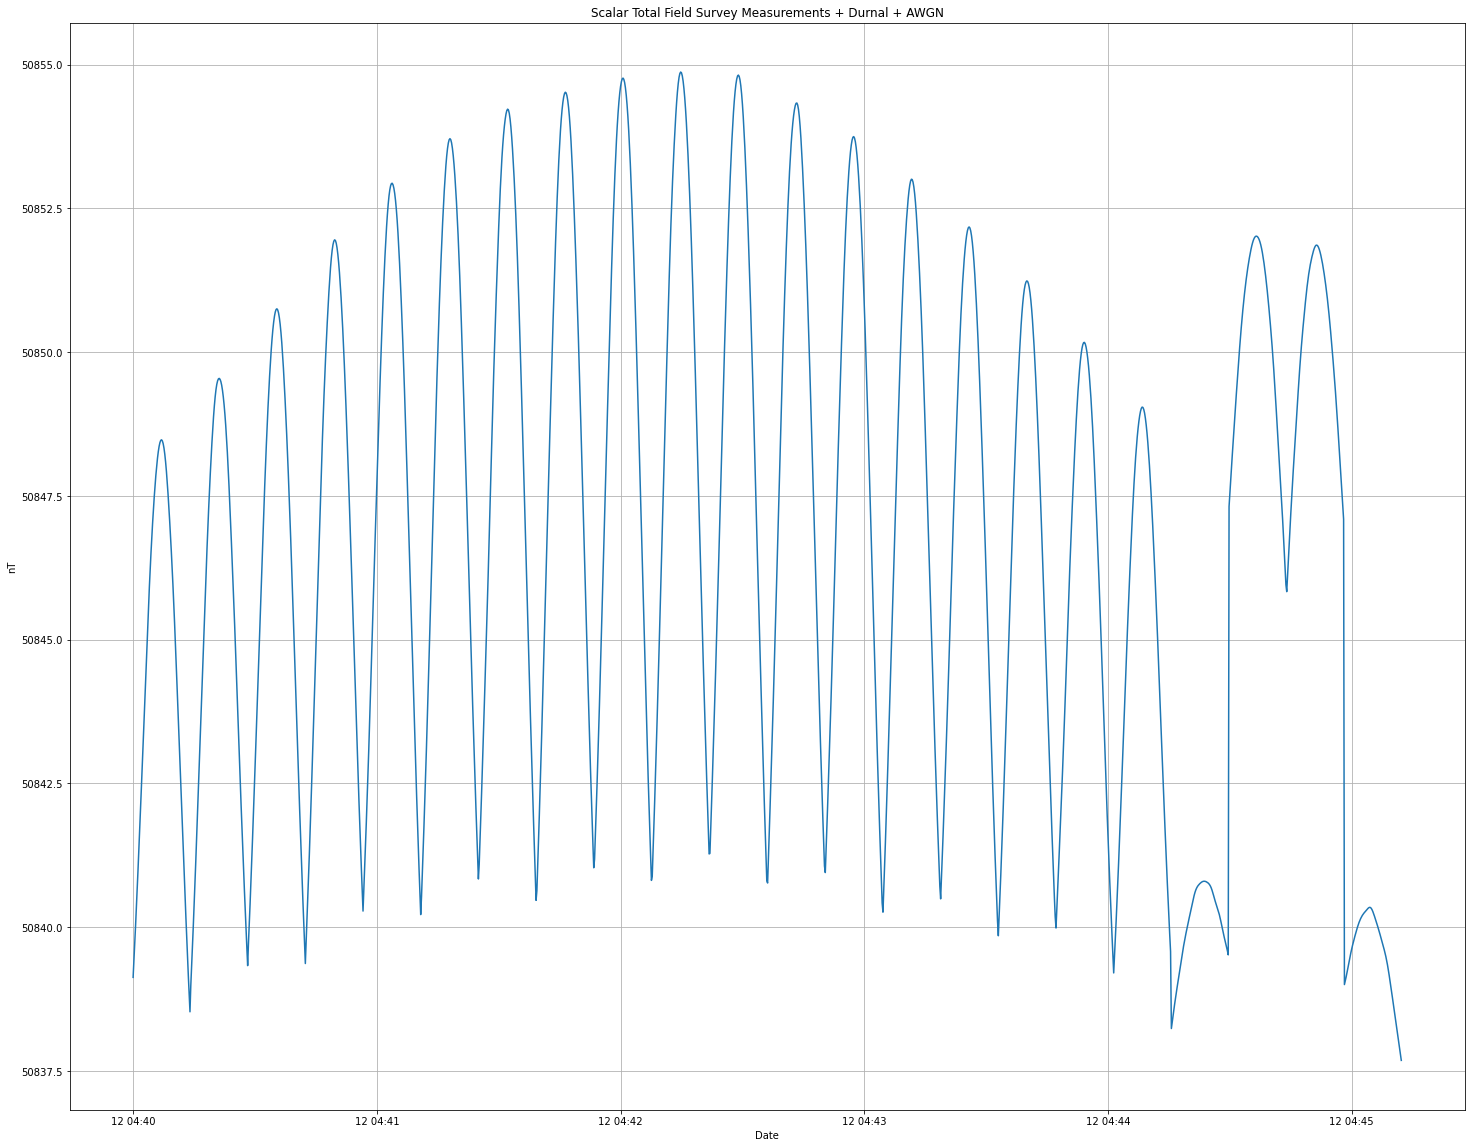

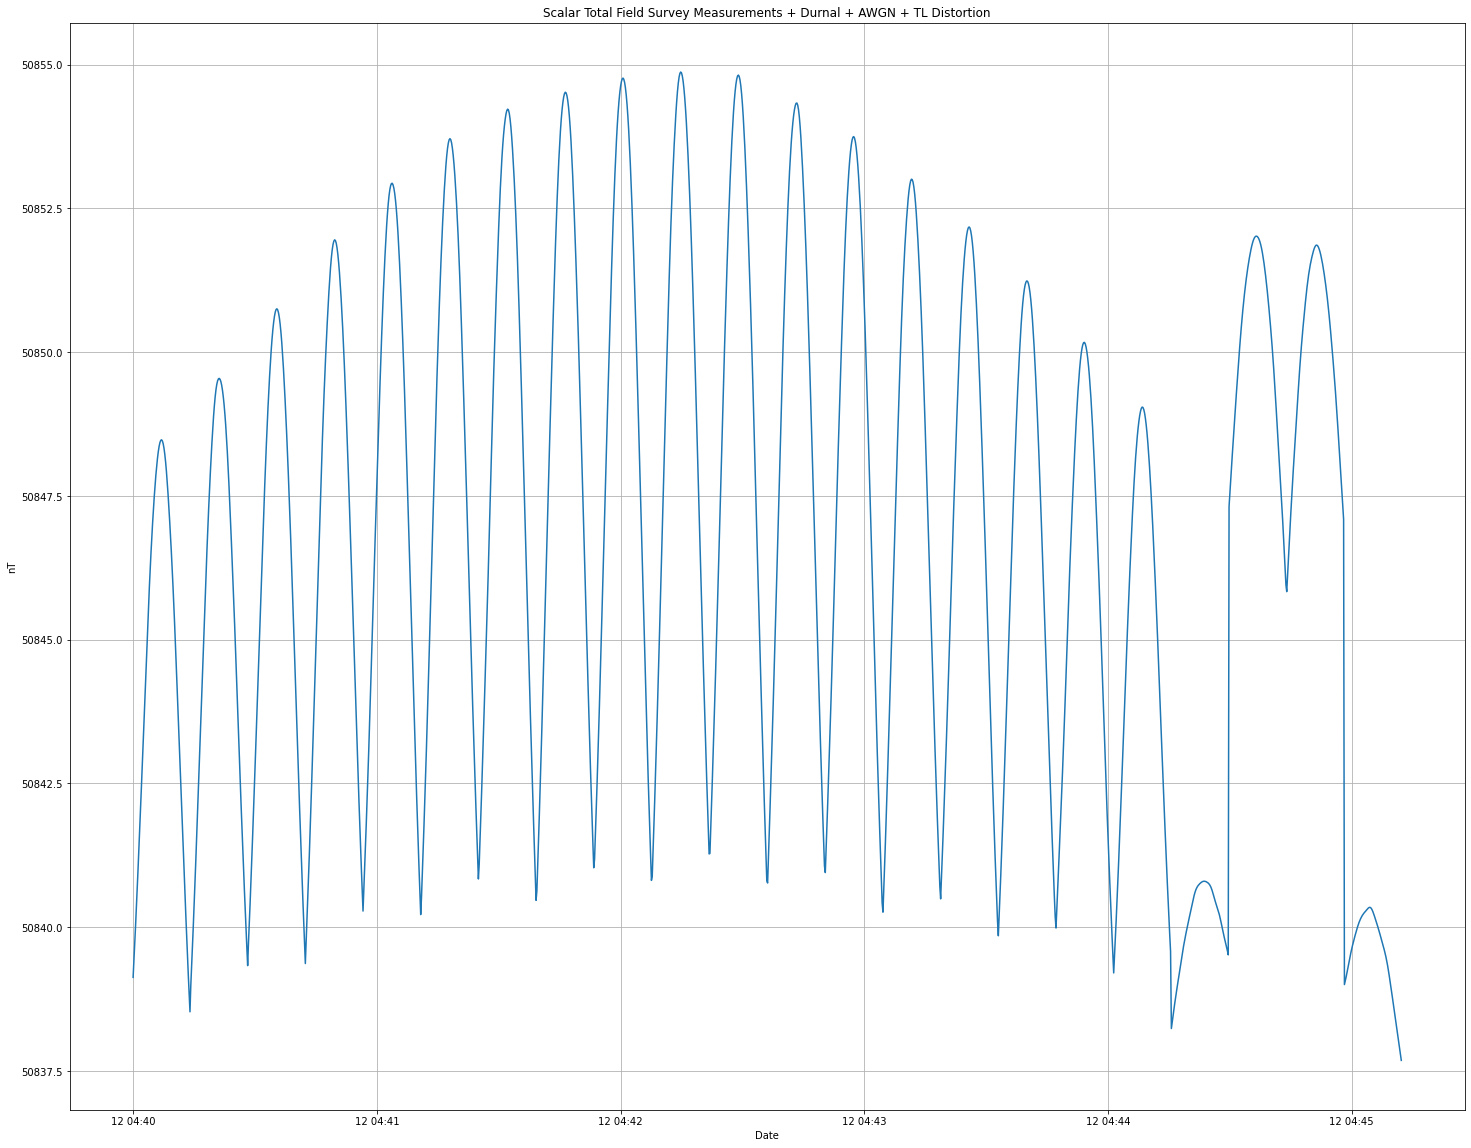

In [11]:
survey_df = sim.gen_survey_data(out_dir         = map_out_dir,
                                map             = sim_map,
                                survey_height_m = survey_height_m,
                                survey_start_dt = survey_start_dt,
                                survey_vel_mps  = survey_vel_mps,
                                survey_e_buff_m = survey_e_buff_m,
                                survey_w_buff_m = survey_w_buff_m,
                                survey_n_buff_m = survey_n_buff_m,
                                survey_s_buff_m = survey_s_buff_m,
                                sample_hz       = survey_sample_hz,
                                ft_line_dist_m  = survey_ft_line_dist_m,
                                ft_line_dir     = survey_ft_line_dir,
                                a               = spin_a,
                                b               = spin_b,
                                c               = tl_c,
                                terms           = tl_terms,
                                scalar_awgn_std = survey_scalar_awgn_std,
                                diurnal_df      = ref_df,
                                diurnal_dist    = np.array([0, 1]), # [offset (nT), scale]
                                use_tie_lines   = survey_use_tie_lines,
                                tie_dist_m      = survey_tie_dist_m,
                                debug           = debug)